# Diabetic Prediction
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset.

All patients here are females at least 21 years old of Pima Indian heritage.
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In Outcome variable =>  
1 for Diabetic, 0 for Non Diabetic

Business Goal - To build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes?

### The solution is divided into the following sections:
- Data understanding and exploration
- Data cleaning
- Data Analysis
- Data preparation
- Model building
- Prediction and Model evaluation
- Inference

### Data understanding and exploration

In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report,roc_auc_score,roc_curve,auc

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn import svm
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score

from scipy.stats import boxcox

# pip install pandas-profiling 
from pandas_profiling import ProfileReport

from joblib import dump, load


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting Display Max columns and display max rows to None so that it displays all the rows and columns which will 
# help us in initial analysis
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Importing the dataset
data = pd.read_csv("../data/diabetes.csv")
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [4]:
# Using ProfileReport function from pandas_profiling library
# This gives a concise report of the entire dataset
ProfileReport(data)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Checking the dataframe size to understand what amount of data we are dealing with
data.shape

(768, 9)

In [6]:
# Checking the dataframe for the datatypes for all the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
# Doing describe to check the spread of values across all numerical fields
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

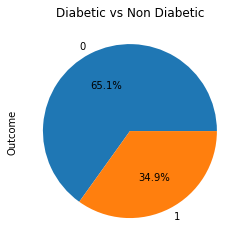

In [8]:
# Plot the percentage of Diabetic vs Non Diabetic Cases
# 1 for Diabetic, 0 for Non Diabetic
plt.title('Diabetic vs Non Diabetic')
data['Outcome'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

### Data Cleaning and Imputation

In [9]:
# Finding out all the column names having 0 in any one of their rows
data.loc[:, (data == 0).any(axis=0)].columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Outcome'],
      dtype='object')

#### Zero value analysis across the columns
- Pregnancy can be 0
- Outcome is the target variable with value 0 or 1 hence ignoring the same
- All other columns value with 0 means data not available, hence replacing with NaN

In [10]:
# Replacing value 0 with NaN
cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
data[cols] = data[cols].replace(0,np.NaN)

In [11]:
# Checking the percentage of missing values across all the columns
round(100*(data[data.columns].isnull().sum()/len(data.index)),2)

Pregnancies                  0.00
Glucose                      0.65
BloodPressure                4.56
SkinThickness               29.56
Insulin                     48.70
BMI                          1.43
DiabetesPedigreeFunction     0.00
Age                          0.00
Outcome                      0.00
dtype: float64

In [12]:
# Printing to check median value of Glucose across different outcomes
print(data.groupby('Outcome')['Glucose'].agg(['median']))

         median
Outcome        
0         107.0
1         140.0


In [13]:
# Created a function to impute median across columns grouped by Outcome
def impute_median(dataFrame,cols):
    for col in cols:
        dataFrame[col] = dataFrame.groupby('Outcome')[col].transform(lambda x: x.fillna(x.median()))

In [14]:
# Calling the function defined above to perform imputation with median
impute_median(data,cols)

In [15]:
# Checking the percentage of missing values across all the columns
round(100*(data[data.columns].isnull().sum()/len(data.index)),2)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

## Data preparation

In [16]:
# Dividing the entire data into X and y that is all independent feature into X and dependent feature to y
X=data
y=data.pop('Outcome')

In [17]:
# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42,stratify=y)

In [19]:
# Fitting the standard scaler on train set and then transforming across all the sets of X
scaler=StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
#Dumping/Storing the scaler object into a file for later use
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

## Model building

In [21]:
# Creating a model list initializing all the model objects
models=[]
models.append(('RF',RandomForestClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('LinearSVM',SVC(kernel='linear')))
models.append(('NonLinearSVM',SVC(kernel='rbf')))
models.append(('MNB',MultinomialNB()))
models.append(('LR',LogisticRegression()))

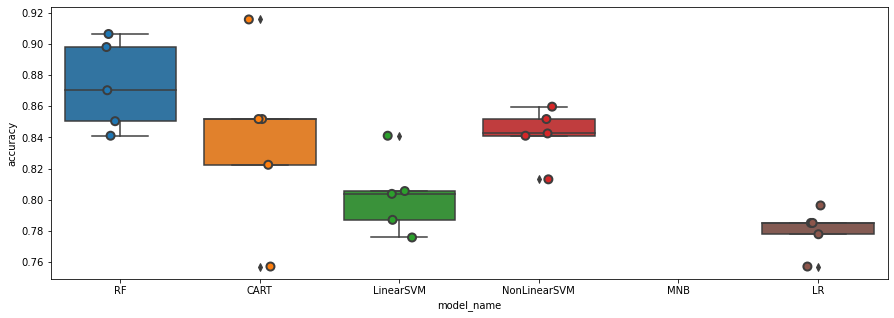

In [22]:
# Checking for model performance across range of models defined above
folds = 5
kfold=KFold(n_splits=folds,random_state=45,shuffle=True)
cv_df = pd.DataFrame(index=range(folds * len(models)))

entries = []

for model_name,model in models:
  # model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=[15,5])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### We see that Random Forest is performing better than other models
#### We see the same in below table

In [23]:
# Priting the model accuracy against each
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
RF              0.873330
NonLinearSVM    0.841693
CART            0.839806
LinearSVM       0.802631
LR              0.780235
MNB                  NaN
Name: accuracy, dtype: float64

In [24]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [25]:
# Fitting the model on train set
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [26]:
# Making predictions on train set
y_train_pred = rfc.predict(X_train)

In [27]:
# Printing classification report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       187

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



In [28]:
# Making predictions on test set
y_test_pred = rfc.predict(X_test)

In [29]:
# Printing classification report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       150
           1       0.84      0.79      0.82        81

    accuracy                           0.87       231
   macro avg       0.87      0.86      0.86       231
weighted avg       0.87      0.87      0.87       231



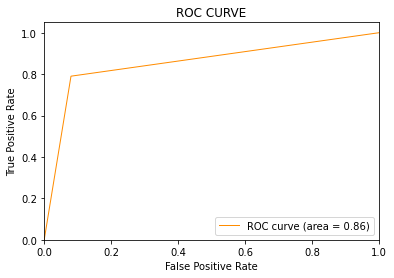

In [30]:
plt.title ("ROC Curve")
#Area under Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
# plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [31]:
XGB_roc_value = roc_auc_score(y_test, y_test_pred)
print("RF roc_value: {0}" .format(XGB_roc_value))

RF roc_value: 0.8550617283950618


In [32]:
# Printing Test Accuracy and confusion matrix
print("Test Accuracy is : ",round(accuracy_score(y_test,y_test_pred),2)*100)
print(confusion_matrix(y_test,y_test_pred))

Test Accuracy is :  87.0
[[138  12]
 [ 17  64]]


In [33]:
# Printing the default parameters
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter Tuning

In [34]:
# Create the parameter grid, using RandomizedSearchCV to do hyperparamater tuning on validation data
# Used RandomizedSearch CV to save computation time

folds = KFold(n_splits=10, shuffle=True,random_state=42)

param_grid = {
    'criterion': ["entropy", "gini"],
    'max_depth': range(0,10,1),
    'min_samples_leaf': range(0,10,1),
    'min_samples_split': range(0,10,1),
    'n_estimators': [40,50,60,70,80,100,200,300], 
    'max_features': ["auto", "sqrt", "log2"]
}
# Create a based model
rf = RandomForestClassifier(bootstrap=True)
# Instantiate the grid search model
rf_grid_search = RandomizedSearchCV(estimator = rf, 
                                    param_distributions = param_grid,
                                    scoring='accuracy',
                                    cv = folds, 
                                    n_jobs = -1,
                                    verbose = 1,
                                    n_iter=500,
                                    random_state=42)

rf_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': range(0, 10),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(0, 10),
                                        'min_samples_split': range(0, 10),
                                        'n_estimators': [40, 50, 60, 70, 80,
                                                         100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=1)

In [35]:
# Printing the best score that we can get using the parameters
# Each time this line is executed post executing the above RandomizedSearchCV it will give different params because
# of very nature RandomizedSearchCV
print('We can get score of :',rf_grid_search.best_score_,' using',rf_grid_search.best_params_)

We can get score of : 0.88277428371768  using {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'gini'}


In [36]:
# model with the best hyperparameters obtained above
rfc_h = RandomForestClassifier(bootstrap=True,
                             criterion="gini",
                             max_depth=6,
                             min_samples_leaf=2, 
                             min_samples_split=2,
                             max_features="sqrt",
                             n_estimators=40,
                             random_state=42)

# fitting on train set
# rfc.fit(np.concatenate((X_train,X_val)),np.concatenate((y_train,y_val)))
rfc_h.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=40, random_state=42)

### Prediction and Model evaluation

In [37]:
# Making predictions on train set
y_train_pred = rfc_h.predict(X_train)

In [38]:
# Printing classification report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       350
           1       0.96      0.94      0.95       187

    accuracy                           0.96       537
   macro avg       0.96      0.96      0.96       537
weighted avg       0.96      0.96      0.96       537



In [39]:
# predict on test set
y_test_pred = rfc_h.predict(X_test)

In [40]:
# Printing classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       150
           1       0.85      0.79      0.82        81

    accuracy                           0.88       231
   macro avg       0.87      0.86      0.86       231
weighted avg       0.88      0.88      0.88       231



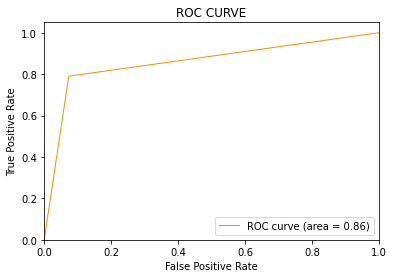

In [41]:
plt.title ("ROC Curve")
#Area under Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
# plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [42]:
RF_roc_value = roc_auc_score(y_test, y_test_pred)
print("RF roc_value: {0}" .format(RF_roc_value))

RF roc_value: 0.858395061728395


In [43]:
# evaluation: Confusion Matrix and Test Accuracy
confusion = metrics.confusion_matrix(y_test, y_test_pred)

# measure accuracy
test_accuracy = round(metrics.accuracy_score(y_test, y_test_pred),2)*100

print("Test Accuracy is : ",test_accuracy, "\n")
print(confusion)

Test Accuracy is :  88.0 

[[139  11]
 [ 17  64]]


In [44]:
# Dumping/Storing the model into a file for later use
dump(rfc_h, '../models/model.joblib')

['../models/model.joblib']

## Inference

We see that the default RandomForest model is having ROC-AUC value of 0.86 and it is overfitting on the training data however the model created post hyperparameter tuning is no longer overfitting and is having the same ROC AUC value of 0.86 and better F1 score.
Hence we will proceed with the model created post hyperparameter tuning.

### Model in Action

In [45]:
# Loading the scaler object from the scaler dump/file
scaler = load('../models/scaler.joblib')

In [46]:
# Loading the model object from the model dump/file
model = load('../models/model.joblib')

In [47]:
# Testing the model on random data
pregnancies = 2
glucose = 180
bloodpressure = 72
skinthickness = 35
insulin = 560
bmi = 33.6
dpf = 0.627
age = 54

row = [pregnancies, glucose, bloodpressure, skinthickness, insulin, bmi, dpf, age]
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [48]:
# Transform the inference data same as training data
df = pd.DataFrame([row], columns = cols)
X = scaler.transform(df)
features = pd.DataFrame(X, columns = cols)

In [49]:
# Make predictions using the already built model [0: healthy, 1:diabetes]
if (model.predict(features)==0):
    print("This is a healthy person!")
else: 
    print("This person has high chances of having diabetes!")

This person has high chances of having diabetes!
